# NBA Tracking - Player motion cuts
This notebook is a  basic attempt to apply the method from [this paper](http://www.sloansportsconference.com/wp-content/uploads/2017/02/1624.pdf) to separate player movement from NBA tracking data into distinct "cuts". I didn't actually make any attempt to replicate the broader method of the paper using bezier curves to do action templating or LDA to find similar possessions.

In [1]:
# read in data
import json
import scipy.spatial.distance as spdist
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


read in some old tracking data

In [2]:
nba_fn = '0021500492.json'

nba_fo = open(nba_fn)
nba = json.load(nba_fo)

The data format of NBA tracking data is a JSON file. Reading the file in results in a dictionary object whose values are the game date, an ID for the game and a list of "events" each of which is a dictionary which represents (I think) the data for a given possession. See [this blog post](http://savvastjortjoglou.com/nba-play-by-play-movements.html) for more info on the structure of the tracking data

In [95]:
nba.keys()

[u'gamedate', u'gameid', u'events']

In [51]:
nba['events'][0].keys()

[u'eventId', u'visitor', u'moments', u'home']

The `moments` key of each `event` containts the actual tracking location data. Some events contain no frame data, so filter them out from a list of the events

In [3]:
game_events = [i for i in nba['events'] if len(i['moments']) != 0]
# columns for each frame of location data
mom_columns = ['team_id','player_id','x','y','z']
# metadata columns for each event
mom_attr = ['quarter','unix_ts','game_clock_sec','shot_clock_sec','extra']

Loop through the events and parse the moment data for a given play

In [74]:
e_i = 15
ev = game_events[e_i] 

In [76]:
# positional data for the given play 
ev_frames = pd.DataFrame()
# copy the moments
ev_moments = [i for i in ev['moments']]
# get the player info from the play (home/away team players)
ev_players = ev['home']['players'] + ev['visitor']['players']
# add them to a DF
player_df = pd.DataFrame(ev_players).set_index('playerid')

parse the positional data (position of each of the 10 players, plus the ball) into a DF for each moment (0.05 second time slice)

In [78]:
# list of DFs for each moment 
poss_data = []
print 'Parsing play ', e_i
# positional data for the given play 
ev_frames = pd.DataFrame()
# copy the moments
ev_moments = [i for i in ev['moments']]
# get the player info from the play (home/away team players)
ev_players = ev['home']['players'] + ev['visitor']['players']
# add them to a DF
player_df = pd.DataFrame(ev_players).set_index('playerid')
for m_i, ev_m in enumerate(ev_moments):
    # location data
    ev_player_m = ev_m[5]
    # metadata for each moment
    attr_vals = ev_m[:5]
    ev_mdf = pd.DataFrame(ev_player_m, columns=mom_columns)
    ev_m_attrs = pd.DataFrame(map(lambda x: attr_vals,ev_player_m),columns=mom_attr)
    # side-to-side concatenate the metadata with the positions
    ev_m_data = pd.concat([ev_mdf,ev_m_attrs],axis=1)
    # label the event/moment on the data
    ev_m_data['event'] = e_i
    ev_m_data['moment'] = m_i
    poss_data.append(ev_m_data)

0


In [79]:
# concat all the positional data together
poss_df = pd.concat(poss_data).reset_index(drop=True)

### Data Analysis

In [81]:
poss_df.head()

,team_id,player_id,x,y,z,quarter,unix_ts,game_clock_sec,shot_clock_sec,extra,event,moment
0,-1,-1,8.86395,23.51988,4.69182,1,1451695396038,608.31,13.36,None,0,0
1,1610612761,2449,4.91692,1.69034,0.00000,1,1451695396038,608.31,13.36,None,0,0
2,1610612761,201960,11.88314,47.00312,0.00000,1,1451695396038,608.31,13.36,None,0,0
3,1610612761,200768,30.68948,16.84961,0.00000,1,1451695396038,608.31,13.36,None,0,0
4,1610612761,201942,13.70119,41.32074,0.00000,1,1451695396038,608.31,13.36,None,0,0


Describe the positional values. The limits of the court range from 0-94 in the X direction and 0-50 in the Y direction

In [80]:
poss_df[['x','y']].describe()

,x,y
count,8800.000000,8800.000000
mean,30.498433,28.279272
std,24.871331,11.231248
min,-0.032800,1.278380
25%,9.858683,20.590338
50%,22.298100,28.910000
75%,42.579268,36.803565
max,99.007640,48.770370


Plot everyone and the ball moving over time

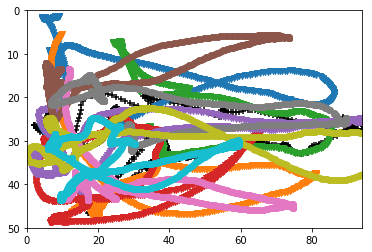

In [82]:
fig, ax = plt.subplots()
fig,
ax.axis([0,94,50,0])
for player in poss_df['player_id'].unique():
    player_vals = poss_df.query('player_id == @player')
    if player == -1:
        ax.scatter(x=player_vals['x'],y=player_vals['y'],marker='+',c='black')
    elif player_vals['team_id'].iloc[0] == 1610612761:
        ax.scatter(x=player_vals['x'],y=player_vals['y'],marker='v')
    else:
        ax.scatter(x=player_vals['x'],y=player_vals['y'],marker='o')

kind of hard to see the movement, so we could split it on player and color by game clock time elapsed

In [83]:
non_ball = poss_df.team_id != -1

<class 'matplotlib.figure.Figure'>


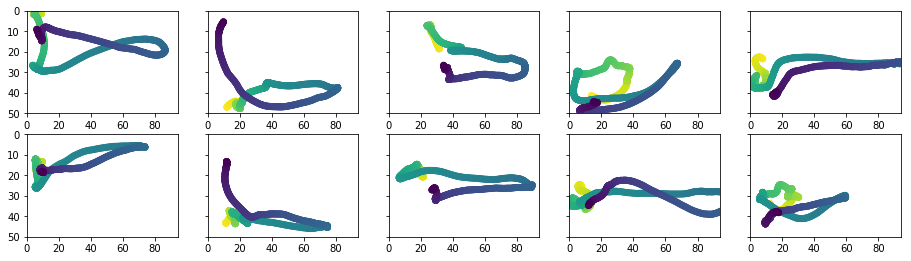

In [84]:
poss_team_players = poss_df.loc[non_ball].groupby('team_id').player_id.unique()
poss_teams = poss_team_players.index
fig, axes = plt.subplots(2,5,sharey=True, figsize=[15.66,4.16])
for t_i, axrow in enumerate(axes):
    team = poss_teams[t_i]
    players = poss_team_players.loc[team]
    for p_i, ax in enumerate(axrow):
        player = players[p_i]
        ax.axis([0,94,50,0])
        player_vals = poss_df.query('player_id == @player')
        ax.scatter(x=player_vals['x'],
                   y=player_vals['y'],
                   marker='o',
                   c=player_vals['game_clock_sec'])

### Defining Speed

Define a function for computing the distance between two frames

In [85]:
def court_distance(current, prev):
    delta_x = current['x'] - prev['x']
    delta_y = current['y'] - prev['y']
    return np.sqrt(np.square(delta_x) + np.square(delta_y))

Add speed to the dataframe in feet per second, and a smoothed version which is the center of a 5-frame rolling mean

In [86]:
poss_df['dist_prev_frame'] = court_distance(poss_df,poss_df.groupby('player_id').shift(1))

In [87]:
poss_df['speed_fs'] = poss_df['dist_prev_frame'] / 0.25

In [88]:
poss_df['smooth_speed'] = (poss_df.groupby('player_id')
                                  .rolling(5, center=True)
                                  .speed_fs
                                  .mean()
                                  .reset_index(0,drop=True)
                            )

**Plot player speeds**  
Smoothed speed in orange, raw in blue, game clock on the x-axis. There's a bit of a jump  in position for several players, so the smoothed speed helps reduce that a bit.

In [89]:
has_speed_vals = (poss_df[['smooth_speed','speed_fs']].isnull().sum(axis=1) == 0)

<class 'matplotlib.figure.Figure'>


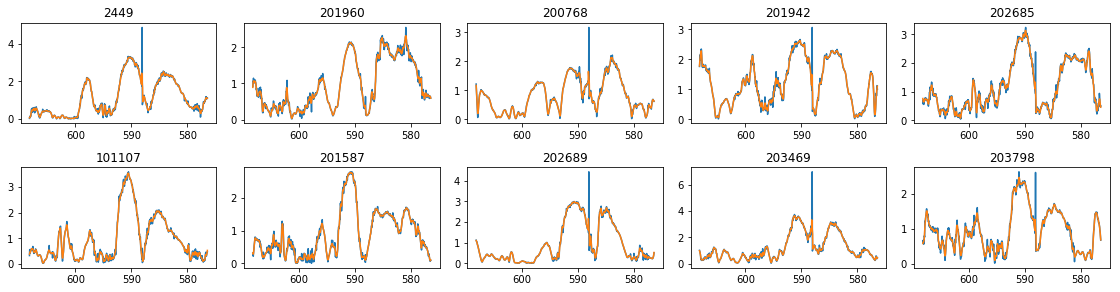

In [130]:
poss_team_players = poss_df.loc[non_ball & has_speed_vals].groupby('team_id').player_id.unique()
poss_teams = poss_team_players.index
fig, axes = plt.subplots(2,5, figsize=[15.66,4.16])
print type(fig)
for t_i, axrow in enumerate(axes):
    team = poss_teams[t_i]
    players = poss_team_players.loc[team]
    for p_i, ax in enumerate(axrow):
        player = players[p_i]
        player_idx = poss_df.player_id == player
        player_vals = poss_df.loc[non_ball & has_speed_vals & player_idx]
        ax.invert_xaxis()
        ax.plot(player_vals['game_clock_sec'],
                   player_vals['speed_fs'])
        ax.plot(player_vals['game_clock_sec'],
                   player_vals['smooth_speed'])
        ax.set_title(str(player))
fig.tight_layout()

### Defining "cuts"
Try dividing the dataframe into discrete movement segments by the players. The paper cited above describes the methodology:

```
At sustained moments of low velocity (> .25 seconds below a threshold of .1 feet per second),
we cut the possession, resulting in a collection of shorter segments.
```

In [139]:
poss_df['low_speed_frame'] = (poss_df['smooth_speed'] < 0.1)

My implementation of this algorithm was sort of roundabout since I was trying to keep the operation a vectorized one on the DataFrame. I computed moments where the speed changed from "low velocity" to not, and vice versa, and labeled frames as belonging to groups of similar consecutive speed at the same low/high ratem then defined "cut" frames as the start/end of segments of at least 5 frames (0.25 seconds) as described

In [140]:
# frame with a change between low and high velocity
prev_lowspeed = poss_df.groupby('player_id').low_speed_frame.shift(1)
poss_df['prev_diff_speed'] = (poss_df['low_speed_frame'] != (prev_lowspeed))
# use cumsum to give a distinct label to period of consecutive frames at the same low/high speed value
poss_df['period_group'] = poss_df.groupby('player_id').prev_diff_speed.cumsum()
# how many lowspeed frames are in the period?
poss_df['period_lowspeed'] = poss_df.groupby(['player_id','period_group']).low_speed_frame.transform('sum')
# define the cut point as start/end of windows of at least 0.1 second at low speed
poss_df['cut_frame'] = ((poss_df['period_lowspeed'] > 5) & 
                        (poss_df['prev_diff_speed']  
                              #| poss_df.groupby(['player_id']).prev_diff_speed.shift(-1))
                        ))

How does this look applied to the data?

<class 'matplotlib.figure.Figure'>


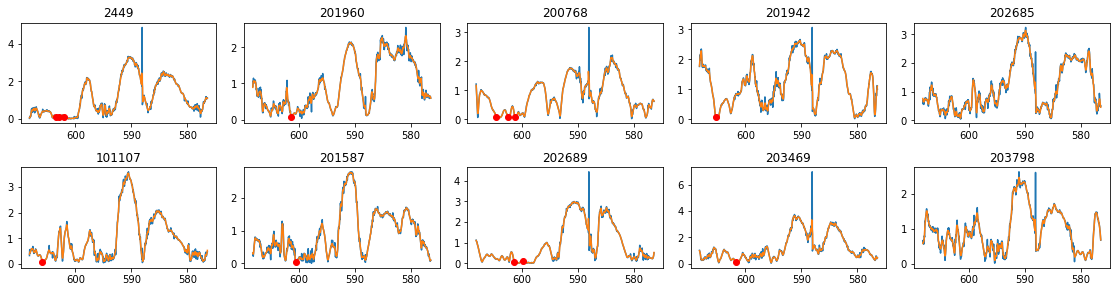

In [141]:
poss_team_players = poss_df.loc[non_ball & has_speed_vals].groupby('team_id').player_id.unique()
poss_teams = poss_team_players.index
fig, axes = plt.subplots(2,5, figsize=[15.66,4.16])
print type(fig)
for t_i, axrow in enumerate(axes):
    team = poss_teams[t_i]
    players = poss_team_players.loc[team]
    for p_i, ax in enumerate(axrow):
        player = players[p_i]
        player_idx = poss_df.player_id == player
        player_vals = poss_df.loc[non_ball & has_speed_vals & player_idx]
        cut_frames = player_vals.loc[player_vals.cut_frame]
        ax.invert_xaxis()
        ax.plot(player_vals['game_clock_sec'],
                   player_vals['speed_fs'])
        ax.plot(player_vals['game_clock_sec'],
                   player_vals['smooth_speed'])
        ax.plot(cut_frames['game_clock_sec'],
                   cut_frames['smooth_speed'],
                   'ro')
        ax.set_title(str(player))
fig.tight_layout()

Hard to tell if I got it exactly like the paper (see figure 1 in it for comparison), but I implemented their algorithm to their description. 

In [142]:
poss_df['cut_segment'] = poss_df.groupby('player_id').cut_frame.cumsum()

Summary of segment length in seconds. Some of the segments are well beyond the paper's stated range of time but they also applied only to offensive players, so that could account for segements without well defined cut points.

In [146]:
(poss_df.loc[non_ball].groupby(['player_id','cut_segment']).size().describe() / 25.0)

count     0.920000
mean     13.913043
std      12.192037
min       0.480000
25%       2.700000
50%       6.960000
75%      25.220000
max      32.000000
dtype: float64